In [251]:
import math
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from mpl_toolkits.axes_grid.inset_locator import inset_axes
%matplotlib inline
import pandas as pd
import os
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from scipy.optimize import curve_fit

In [2]:
file = os.path.join(os.getcwd(),'Datasets','20230109 12ca5 ASMS then add LibQC.csv')
data = pd.read_csv(file)
cols = [a for a in data.columns if "UMAP" in a]

peps = data['Peptide']
labels = data['Label']
C1 = data['UMAP Fingerprint C1']
C2 = data['UMAP Fingerprint C2']

peps_cluster = data[data['Label'] == 'Specific']['Peptide']
C1_cluster = data[data['Label'] == 'Specific']['UMAP Fingerprint C1']
C2_cluster = data[data['Label'] == 'Specific']['UMAP Fingerprint C2']

In [105]:
len(data)

9151

In [3]:
C = np.asarray([(C1s,C2s) for C1s,C2s in zip(C1_cluster,C2_cluster)])

In [4]:
epsy = 0.0931
sampley = 7
model = DBSCAN(eps=epsy, min_samples=sampley) # define the model
print('Cluster detection, eps is ' + str(epsy) + ', sample_min ' + str(sampley))

clusters = [x+1 for x in model.fit_predict(C)] # fit model, predict clusters. Every row has a cluster associated.
# note that the -1 labeled cluster is noise,so we adjusted to 0
uniq_clusters = np.unique(clusters)

Cluster detection, eps is 0.0931, sample_min 7


In [5]:
my_colors = ['tab:blue','tab:orange','tab:green','tab:red',
             'tab:purple','tab:brown','tab:pink','tab:gray',
             'tab:olive','tab:cyan','tab:gray']
cmap = my_colors
j = 0
while len(cmap) < len(uniq_clusters) + 1:
    if j == len(my_colors):
        j = 0
    cmap.append(my_colors[j])
    j += 1

In [6]:
data_clus = pd.DataFrame()
data_clus['Peptide'] = peps_cluster
data_clus['C1'] = C1_cluster
data_clus['C2'] = C2_cluster
data_clus['Cluster'] = clusters

data_ratio = data_clus.copy()

In [108]:
peps_cluster

0       VWRDAEDYATFP
1       TPDWDGPDYAAH
2       EMDAPDYASWEP
3       SVEDDAPDYADF
4       MMDMDLQDYAGL
            ...     
4097    FMRWHDKPDYSH
4098    YEYFTDSHDYAH
4099    LLKYTDRHDYAW
4100    DTDWPDYSSFLF
4103    FLYDVHDYAFEH
Name: Peptide, Length: 3512, dtype: object

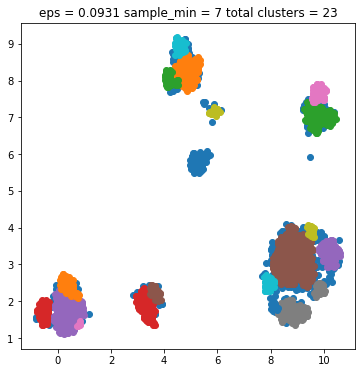

In [8]:
plt.rcParams['figure.figsize'] = (6,6)

fig,ax = plt.subplots(figsize=(6,6))
for i in uniq_clusters:
    rows = data_clus.query('Cluster == @i')
    x = rows['C1']
    y = rows['C2']
    ax.scatter(x,y,label=f'Cluster {i}')
    
# plt.scatter(Center_ave[:,0], Center_ave[:,1], alpha=1, s=200, c='black')
plot_title = f'eps = {epsy} sample_min = {sampley} total clusters = {len(uniq_clusters)}'
plt.title(plot_title,fontsize=12)
plt.savefig(os.path.join(os.getcwd(),'Datasets','Clustering Opt',plot_title + '.png'))

### Now loop and optimize

In [9]:
epsy_list = np.linspace(0.05,0.2,20)
sampley_list = np.arange(8,20,2)

for epsy in epsy_list:
    for sampley in sampley_list:
        model = DBSCAN(eps=epsy, min_samples=sampley)
        clusters = [x+1 for x in model.fit_predict(C)] # fit model, predict clusters. Every row has a cluster associated.
        # note that the -1 labeled cluster is noise,so we adjusted to 0
        uniq_clusters = np.unique(clusters)

        data_clus = pd.DataFrame()
        data_clus['Peptide'] = peps_cluster
        data_clus['C1'] = C1_cluster
        data_clus['C2'] = C2_cluster
        data_clus['Cluster'] = clusters
        
        fig,ax = plt.subplots(figsize=(6,6))
        for i in uniq_clusters:
            rows = data_clus.query('Cluster == @i')
            x = rows['C1']
            y = rows['C2']
            ax.scatter(x,y,label=f'Cluster {i}')

        # plt.scatter(Center_ave[:,0], Center_ave[:,1], alpha=1, s=200, c='black')
        plot_title = f'eps = {epsy} sample_min = {sampley} total clusters = {len(uniq_clusters)}'
        plt.title(plot_title,fontsize=12)
        plt.savefig(os.path.join(os.getcwd(),'Datasets','Clustering Opt',plot_title + '.png'))
        plt.close()

Cluster detection, eps is 0.192105, sample_min 12


Text(0.5, 1.0, 'eps = 0.192105 sample_min = 12 total clusters = 9')

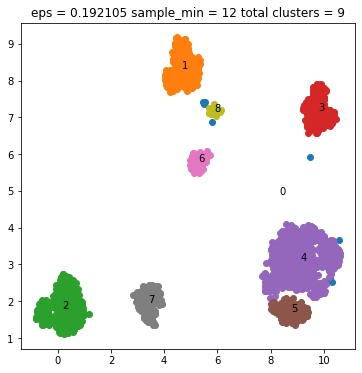

In [10]:
epsy = 0.192105
sampley = 12
model = DBSCAN(eps=epsy, min_samples=sampley) # define the model
print('Cluster detection, eps is ' + str(epsy) + ', sample_min ' + str(sampley))

clusters = [x+1 for x in model.fit_predict(C)] # fit model, predict clusters. Every row has a cluster associated.
# note that the -1 labeled cluster is noise,so we adjusted to 0
uniq_clusters = np.unique(clusters)

my_colors = ['tab:blue','tab:orange','tab:green','tab:red',
             'tab:purple','tab:brown','tab:pink','tab:gray',
             'tab:olive','tab:cyan']
cmap = my_colors
j = 0
while len(cmap) < len(uniq_clusters) + 1:
    if j == len(my_colors):
        j = 0
    cmap.append(my_colors[j])
    j += 1

data_clus = pd.DataFrame()
data_clus['Peptide'] = peps_cluster
data_clus['C1'] = C1_cluster
data_clus['C2'] = C2_cluster
data_clus['Cluster'] = clusters

data_final = data_clus.query('Cluster != 0')

nonclustered = data_clus.query('Cluster == 0')

fig,ax = plt.subplots(figsize=(6,6))
for i in uniq_clusters:
    rows = data_clus.query('Cluster == @i')
    x = rows['C1']
    y = rows['C2']
    cent_x = np.average(x)
    cent_y = np.average(y)
    plt.annotate(i,(cent_x,cent_y))
    ax.scatter(x,y,label=f'Cluster {i}',c=cmap[i])

# plt.scatter(Center_ave[:,0], Center_ave[:,1], alpha=1, s=200, c='black')
plot_title = f'eps = {epsy} sample_min = {sampley} total clusters = {len(uniq_clusters)}'
plt.title(plot_title,fontsize=12)

In [11]:
peps_lib = data[data['Label'] != 'Specific']['Peptide']
C1_lib = data[data['Label'] != 'Specific']['UMAP Fingerprint C1']
C2_lib = data[data['Label'] != 'Specific']['UMAP Fingerprint C2']
label_lib = data[data['Label'] != 'Specific']['Label']

data_lib = pd.DataFrame()
data_lib['Peptide'] = peps_lib
data_lib['C1'] = C1_lib
data_lib['C2'] = C2_lib
data_lib['Cluster'] = np.zeros(len(C1_lib))
data_lib['Label'] = label_lib

data_lib_all = pd.concat([data_lib,nonclustered])

### Plot all data

C:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'UMAP Fingerprint C2')

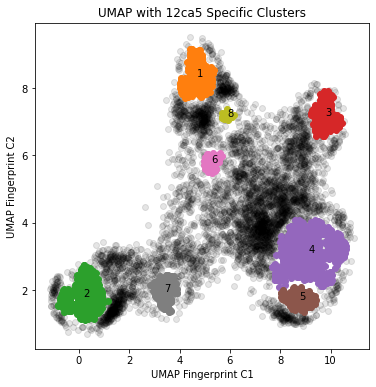

In [12]:
fig,ax = plt.subplots(figsize=(6,6))
ax.scatter(data_lib_all['C1'],data_lib_all['C2'],c='k',alpha=0.1)
centers = []
for i in uniq_clusters:
    rows = data_final.query('Cluster == @i')
    x = rows['C1']
    y = rows['C2']
    cent_x = np.average(x)
    cent_y = np.average(y)
    if not math.isnan(cent_x):
        centers.append((cent_x,cent_y))
    plt.annotate(i,(cent_x,cent_y))
    ax.scatter(x,y,label=f'Cluster {i}',c=cmap[i])
ax.set_title('UMAP with 12ca5 Specific Clusters')
ax.set_xlabel('UMAP Fingerprint C1')
ax.set_ylabel('UMAP Fingerprint C2')

In [13]:
C_all = np.asarray([(C1s,C2s) for C1s,C2s in zip(C1,C2)])

C_lib = np.asarray([(C1s,C2s) for C1s,C2s in zip(C1_lib,C2_lib)])
len(C_all),len(C_lib)

(9151, 5639)

In [14]:
def find_distance(coord,point):
    x_1 = coord[0]
    y_1 = coord[1]
    x_2 = point[0]
    y_2 = point[1]
    return np.sqrt((x_2 - x_1)**2 + (y_2 - y_1)**2)

In [15]:
clusters_spec = np.unique(data_final['Cluster'])
print(len(centers),len(clusters_spec))

8 8


In [16]:
# all points

rs_all = []
for center in centers:
    r_sub = []
    for p in C_all:
        r = find_distance(center,p)
        r_sub.append(r)
    rs_all.append(r_sub)
    
# individual cluster distances

rs_spec = []

for i,center in enumerate(centers):
    r_sub = []
    data_sub = data_final.query('Cluster == @i+1')
    sub_C1 = data_sub['C1']
    sub_C2 = data_sub['C2']
    point_list = [(c1,c2) for c1,c2 in zip(sub_C1,sub_C2)]
    for p in point_list:
        r = find_distance(center,p)
        r_sub.append(r)
    rs_spec.append(r_sub)
    
# library points

rs_lib = []
for center in centers:
    r_sub = []
    for p in C_lib:
        r = find_distance(center,p)
        r_sub.append(r)
    rs_lib.append(r_sub)

1.0
1.0


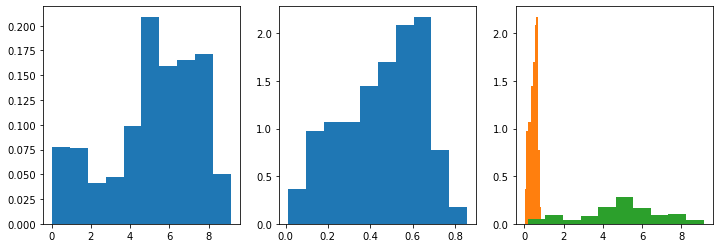

In [17]:
fig,axs = plt.subplots(ncols=3,nrows=1,figsize=(12,4))
axs[0].hist(rs_all[0],density = True)
axs[1].hist(rs_spec[0],density = True)
axs[2].hist(rs_lib[0],density = True)

# pdf, bins, patches = axs[2].hist(rs_all[0],density=True)
# print(np.sum(pdf * np.diff(bins)))
pdf, bins, patches = axs[2].hist(rs_spec[0],density=True)
print(np.sum(pdf * np.diff(bins)))
pdf, bins, patches = axs[2].hist(rs_lib[0],density=True)
print(np.sum(pdf * np.diff(bins)))

In [18]:
r_max = max([max(a) for a in rs_all])
bins = np.linspace(0,r_max,1000)

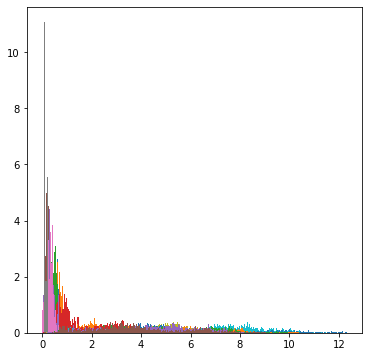

In [201]:
pdf_specs = []
bins_specs = []
patches_specs = []

for rs in rs_spec:
    pdf_spec, bins_spec, patches_spec = plt.hist(rs,bins=bins,density=True)
    pdf_specs.append(pdf_spec)
    bins_specs.append(bins_spec)
    patches_specs.append(patches_spec)
   
pdf_libs = []
bins_libs = []
patches_libs = []
for rs in rs_lib:
    pdf_lib, bins_lib, patches_lib = plt.hist(rs,bins=bins,density=True)
    pdf_libs.append(pdf_lib)
    bins_libs.append(bins_lib)
    patches_libs.append(patches_lib)

In [202]:
r_50s = []
for i,pdf in enumerate(pdf_specs):
    tot = 0
    bins_use = bins_specs[i]
    for j,p in enumerate(pdf):
        tot += p * np.diff(bins_use)[j]
        if tot > 0.9:
            r_50s.append(bins_use[j])   # bins represent upper end of histogram x axis, which is r
            print(bins_use[j])
            break
            
r_p1s = []
for i,pdf in enumerate(pdf_specs):
    tot = 0
    bins_use = bins_specs[i]
    for j,p in enumerate(pdf):
        tot += p * np.diff(bins_use)[j]
        if tot > 0.05:
            r_p1s.append(bins_use[j])   # bins represent upper end of histogram x axis, which is r
            print(bins_use[j])
            break

0.6775398272516363
0.8007288867519338
0.591307485601428
1.2565284069030347
0.5789885796513983
0.295653742800714
0.4804373320511603
0.18478358925044627
0.12318905950029752
0.13550796545032726
0.08623234165020825
0.20942140115050575
0.06159452975014876
0.06159452975014876
0.06159452975014876
0.06159452975014876


In [203]:
r_p1s

[0.12318905950029752,
 0.13550796545032726,
 0.08623234165020825,
 0.20942140115050575,
 0.06159452975014876,
 0.06159452975014876,
 0.06159452975014876,
 0.06159452975014876]

#### Now we have the r_50, redo histogram over appropriate range

<ipython-input-204-e7408b6a16c2>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-204-e7408b6a16c2>:19: RuntimeWarning: invalid value encountered in double_scalars
  ratio_spec = [a/(a + b) for a,b in zip(p,pl)]
<ipython-input-204-e7408b6a16c2>:20: RuntimeWarning: invalid value encountered in double_scalars
  ratio_lib = [b/(a + b) for a,b in zip(p,pl)]


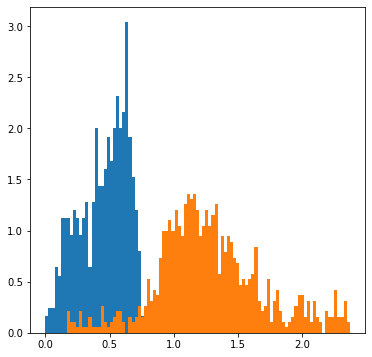

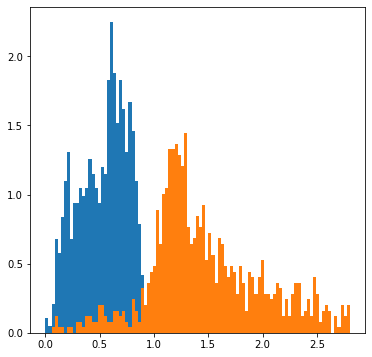

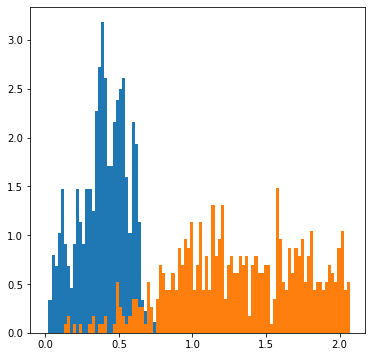

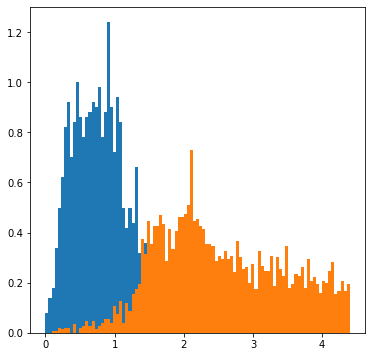

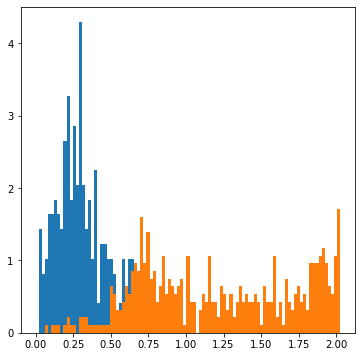

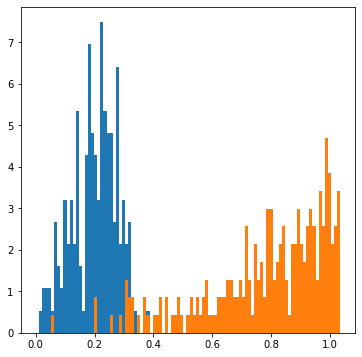

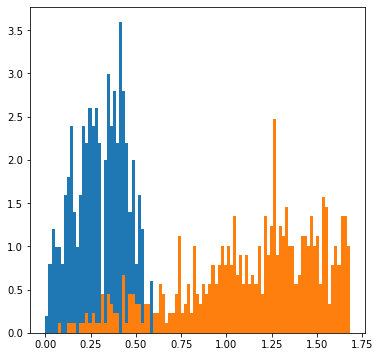

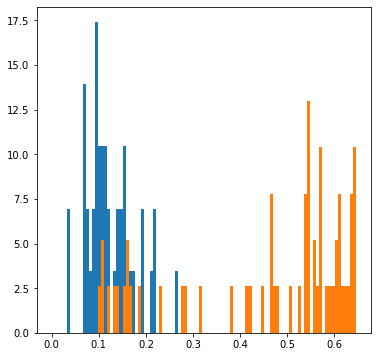

In [204]:
ratios_spec = []
ratios_lib = []
rs_plot = []
rs_plot_norm = []
ps_spec = []
ps_lib = []

factor = 3.5
steps = 100

for i,r50 in enumerate(r_50s):
    fig, ax = plt.subplots()
    bin_50s = np.linspace(0,r50*factor,steps)
    
    p,b,o = ax.hist(rs_spec[i],bins=bin_50s,density=True)
    pl,bl,ol = ax.hist(rs_lib[i],bins=bin_50s,density=True)
    fig.show()
    
    ratio_spec = [a/(a + b) for a,b in zip(p,pl)]
    ratio_lib = [b/(a + b) for a,b in zip(p,pl)]
    
    ps_spec.append(p)
    ps_lib.append(pl)
    
    rs_plot.append(b[1:])
    rs_plot_norm.append([t/r50 for t in b[1:]])
    ratios_spec.append(ratio_spec)
    ratios_lib.append(ratio_lib)

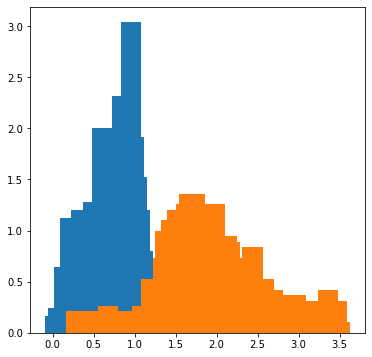

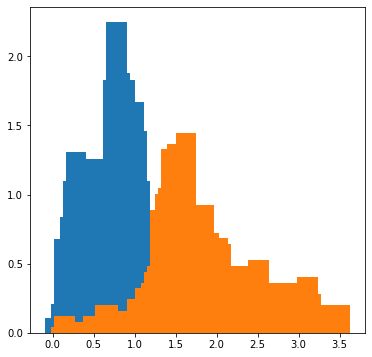

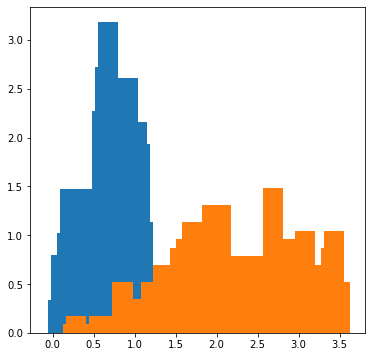

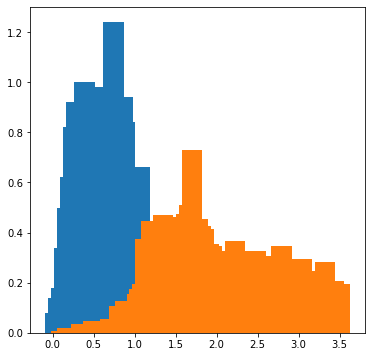

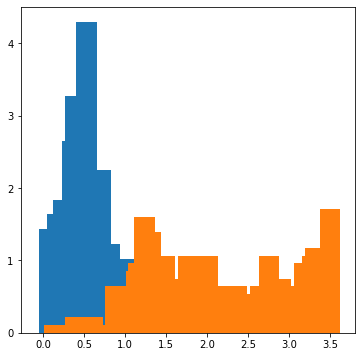

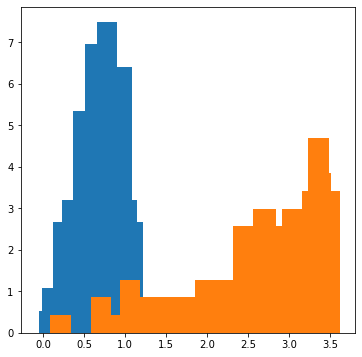

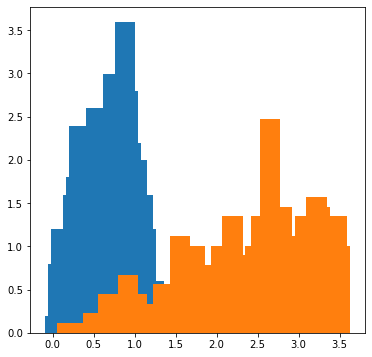

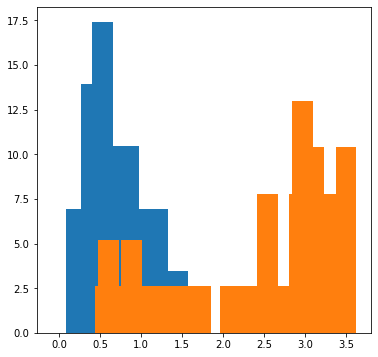

In [205]:
### normalize x axis
for i,r_n in enumerate(rs_plot_norm):
    fig, ax= plt.subplots()
    ax.bar(r_n,ps_spec[i],width=0.25)
    ax.bar(r_n,ps_lib[i],width=0.25)

In [206]:
norms_spec = []
norms_lib = []
rs_norm_plot = []

bins_spec = []
bins_lib = []

for i,r50 in enumerate(r_50s):
    norms_spec.append([a/r50 for a in rs_spec[i]])
    norms_lib.append([b/r50 for b in rs_lib[i]])

<ipython-input-207-5e0529f37fd8>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


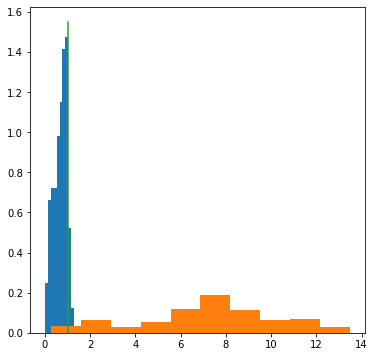

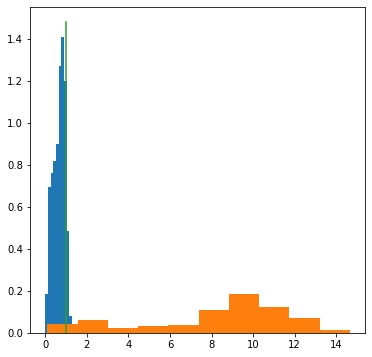

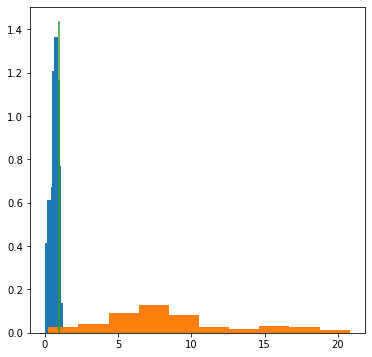

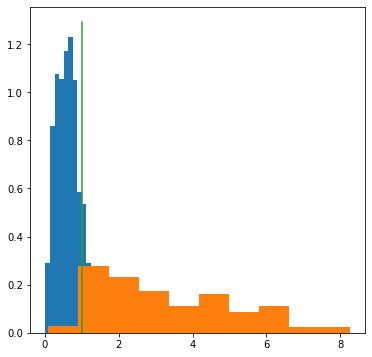

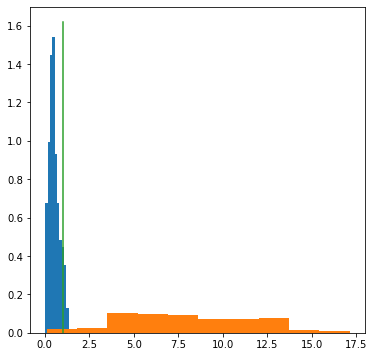

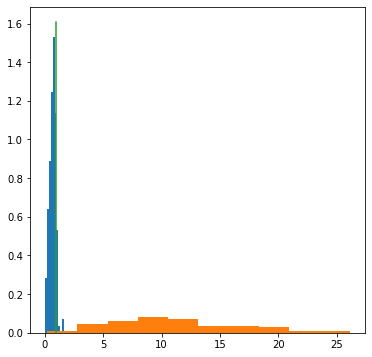

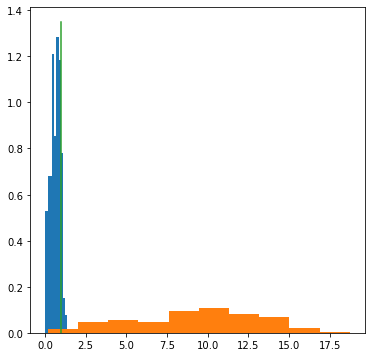

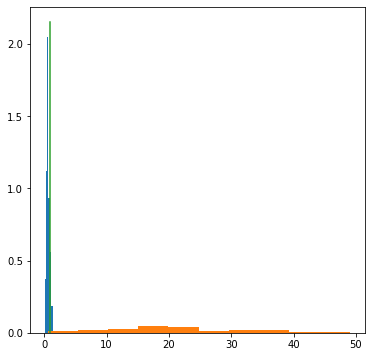

In [207]:
for n_s,n_l in zip(norms_spec,norms_lib):
    fig, ax = plt.subplots()
    p,b,o = ax.hist(n_s,density=True)
    pl,bl,ol = ax.hist(n_l,density=True)
    ax.plot([1,1],ax.get_ylim())
    fig.show()

In [208]:
def nan_fixer(array):
    new_array = []
    for i,val in enumerate(array):
        if math.isnan(val):
            if i == 0:
                new_array.append(1) # should be center of cluster, should have apoint
            else:
                try:
                    if math.isnan(array[i-1]) or math.isnan(array[i+1]):
    #                     print('Multiple nans!')
                        new_array.append(0)
                    else:
                        new_array.append((array[i-1] + array[i+1])/2)
                except IndexError:
    #                 print('error')
                    new_array.append(0)
        else:
            new_array.append(val)
    return new_array

def nan_replacer(array,new_val=0):
    new_array = []
    for val in array:
        if math.isnan(val):
            if i == 0:
                new_array.append(1)
            else:
                new_array.append(new_val)
        else:
            new_array.append(val)
    return new_array

rat_spec_nonans = [nan_fixer(array) for array in ratios_spec]
rat_lib_nonans = [nan_fixer(array) for array in ratios_lib]

rat_spec_replace = [nan_replacer(array) for array in ratios_spec]
rat_lib_replace = [nan_replacer(array) for array in ratios_lib]

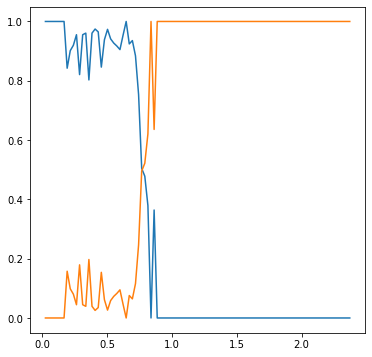

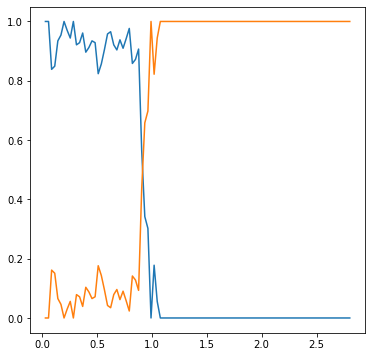

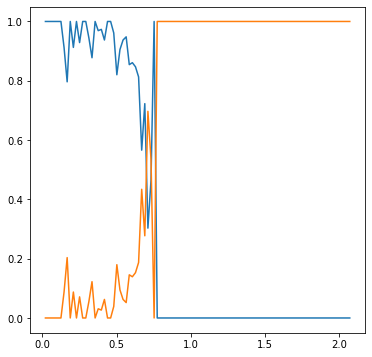

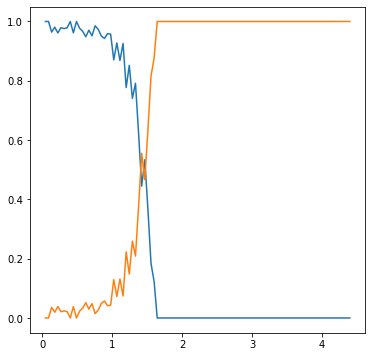

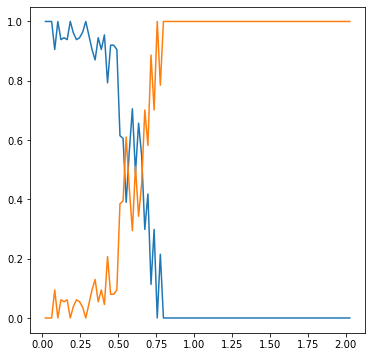

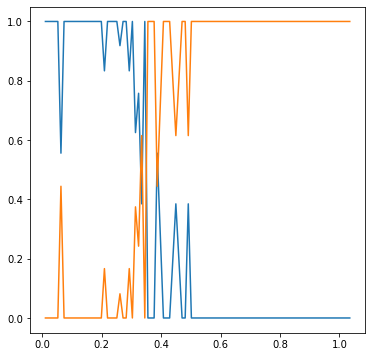

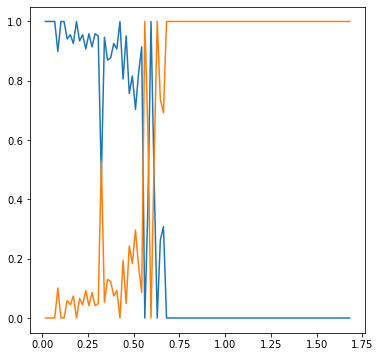

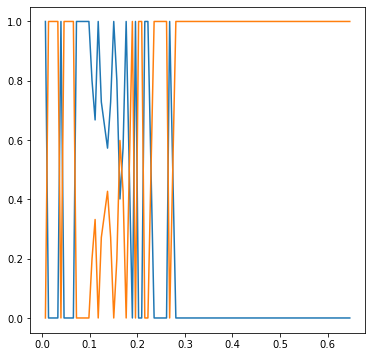

In [209]:
for rat_spec,rat_lib,r_plot in zip(rat_spec_nonans,rat_lib_nonans,rs_plot):
    fig, ax = plt.subplots()
    ax.plot(r_plot,rat_spec)
    ax.plot(r_plot,[1 - a for a in rat_spec])

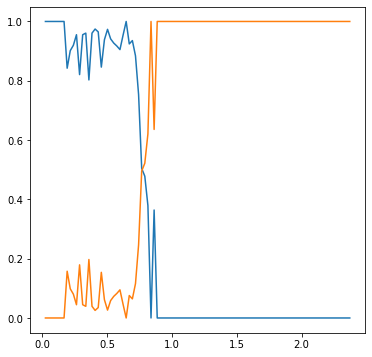

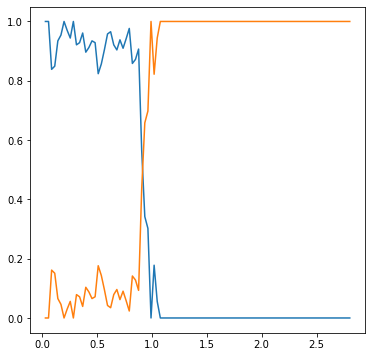

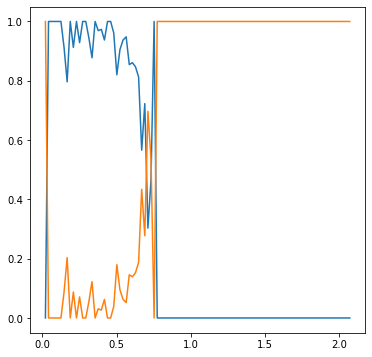

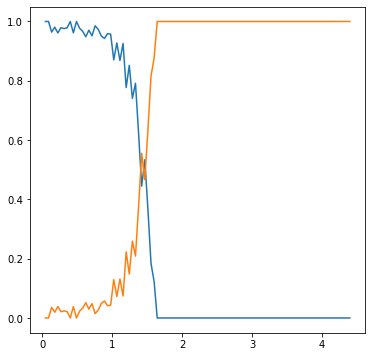

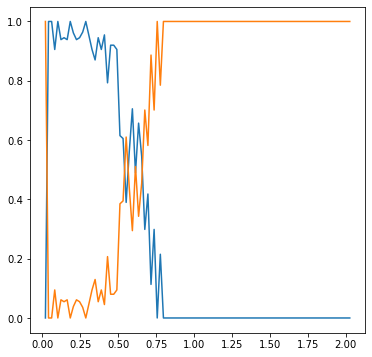

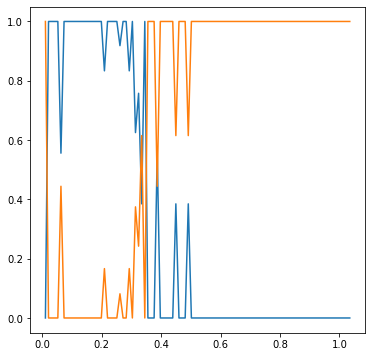

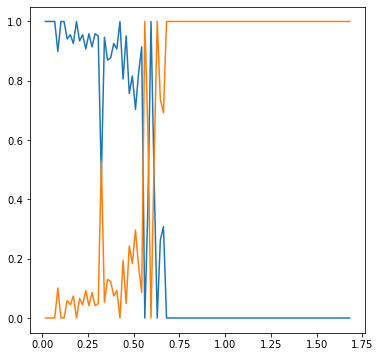

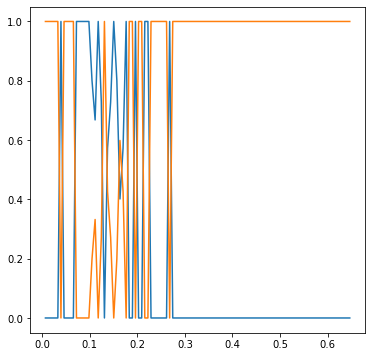

In [210]:
for rat_spec,rat_lib,r_plot in zip(rat_spec_replace,rat_lib_replace,rs_plot):
    fig, ax = plt.subplots()
    ax.plot(r_plot,rat_spec)
    ax.plot(r_plot,[1 - a for a in rat_spec])

#### filtered

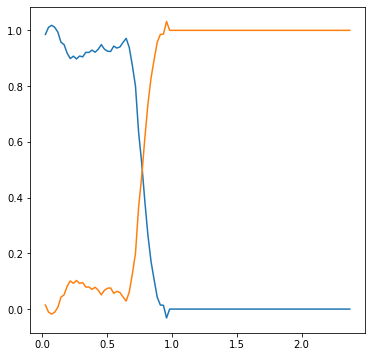

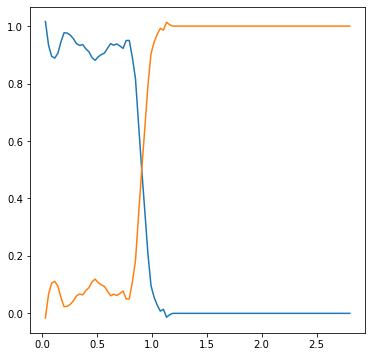

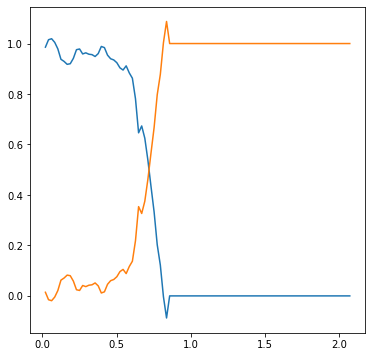

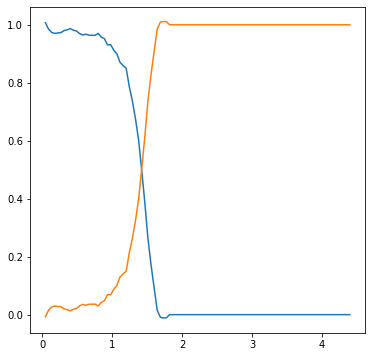

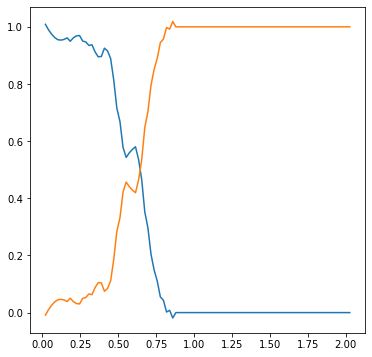

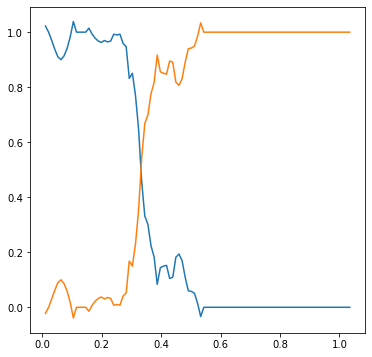

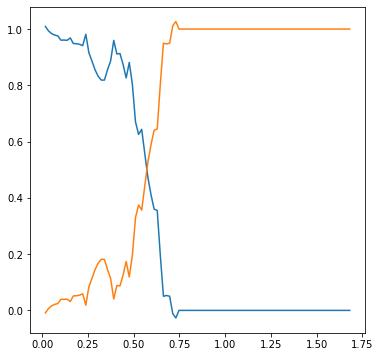

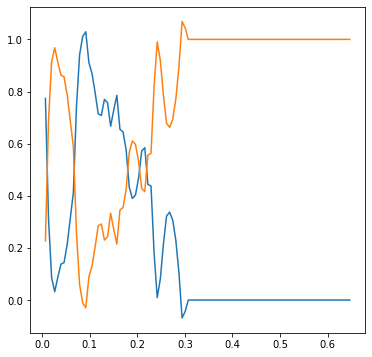

In [211]:
for rat_spec,rat_lib,r_plot in zip(rat_spec_nonans,rat_lib_nonans,rs_plot):
    fig, ax = plt.subplots()
    ax.plot(r_plot,savgol_filter(rat_spec,10,3))
    ax.plot(r_plot,savgol_filter([1 - a for a in rat_spec],10,3))

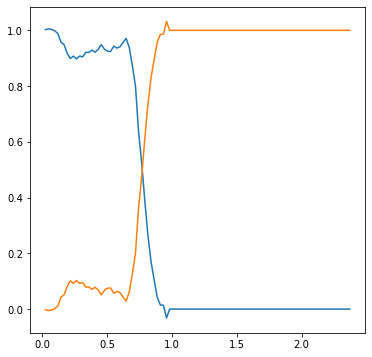

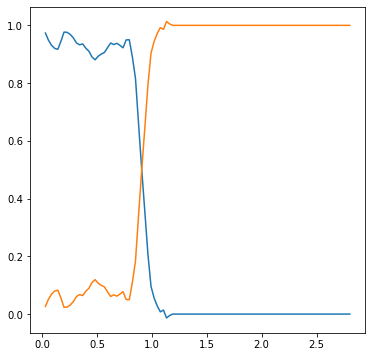

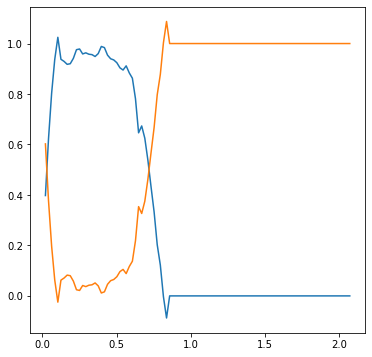

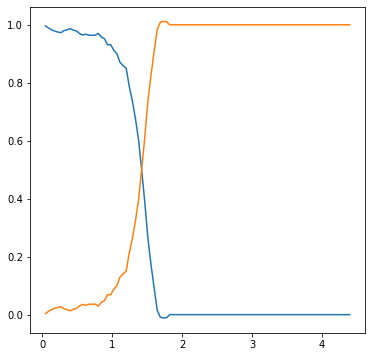

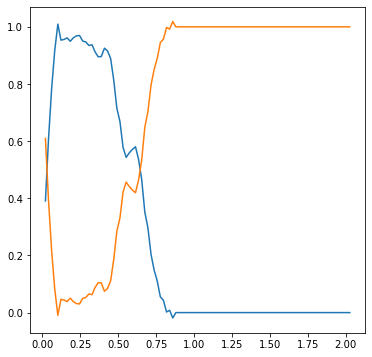

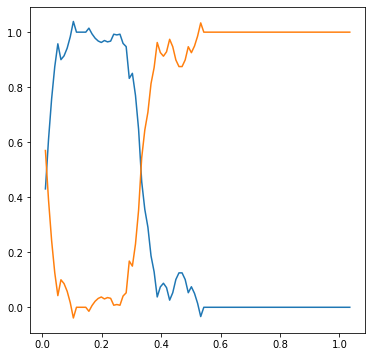

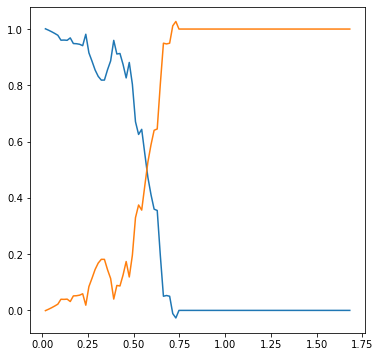

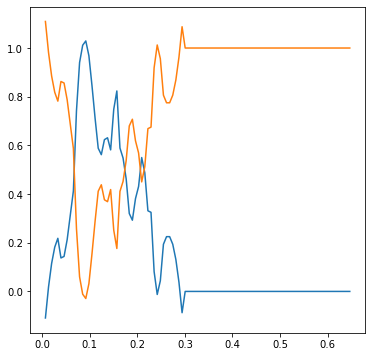

In [212]:
for rat_spec,rat_lib,r_plot in zip(rat_spec_replace,rat_lib_replace,rs_plot):
    fig, ax = plt.subplots()
    ax.plot(r_plot,savgol_filter(rat_spec,10,2))
    ax.plot(r_plot,savgol_filter([1 - a for a in rat_spec],10,2))

## Try doing sum of probability density as function of x

<ipython-input-213-51af6d503d56>:29: RuntimeWarning: invalid value encountered in double_scalars
  ratio_spec = [a/(a + b) for a,b in zip(p,pl)]
<ipython-input-213-51af6d503d56>:30: RuntimeWarning: invalid value encountered in double_scalars
  ratio_lib = [b/(a + b) for a,b in zip(p,pl)]


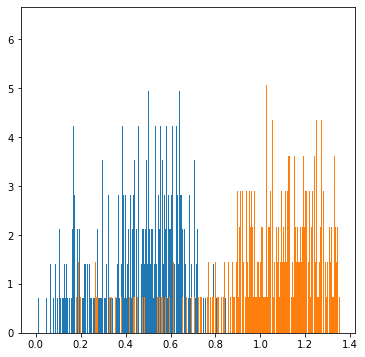

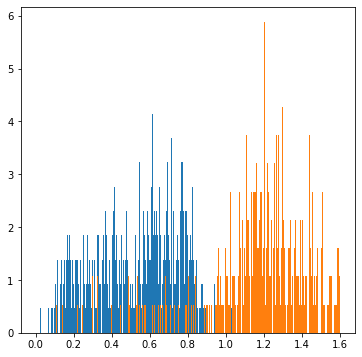

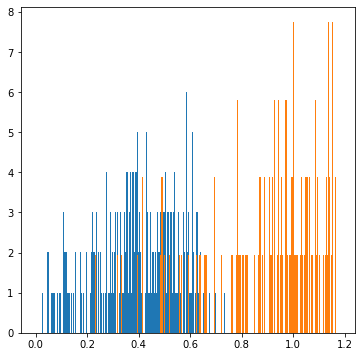

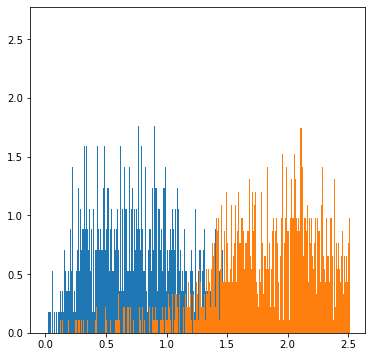

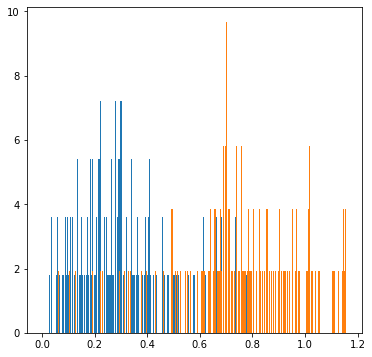

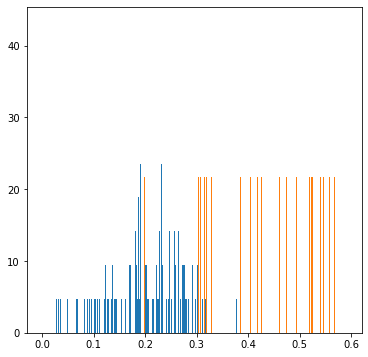

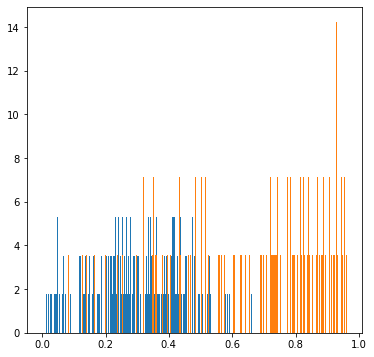

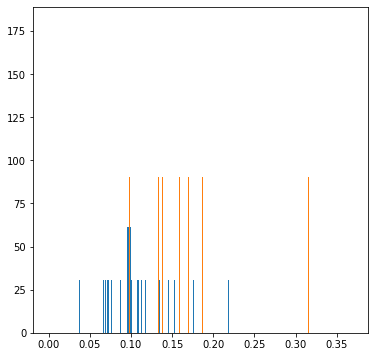

In [213]:
ratios_spec = []
ratios_lib = []
rs_plot = []

ps = []
bs = []
os = []

pls = []
bls = []
ols = []

factor = 2

for i,r50 in enumerate(r_50s):
    fig, ax = plt.subplots()
    bin_50s = np.linspace(0,r50*factor,500)
    
    p,b,o = ax.hist(rs_spec[i],bins=bin_50s,density=True)
    pl,bl,ol = ax.hist(rs_lib[i],bins=bin_50s,density=True)
    
    ps.append(p)
    bs.append(b)
    os.append(o)
    pls.append(pl)
    bls.append(bl)
    ols.append(ol)
    
    ratio_spec = [a/(a + b) for a,b in zip(p,pl)]
    ratio_lib = [b/(a + b) for a,b in zip(p,pl)]
    
    rs_plot.append(b[1:])
    ratios_spec.append(ratio_spec)
    ratios_lib.append(ratio_lib)

In [214]:
densities = []
for i,pdf in enumerate(ps):
    tot = 0
    bins_use = bs[i]
    density = [0]
    for j,p in enumerate(pdf):
        tot += p * np.diff(bins_use)[j]
        density.append(tot)
    densities.append(density)
    
densities_l = []
for i,pdf in enumerate(pls):
    tot = 0
    bins_use = bls[i]
    density = [0]
    for j,p in enumerate(pdf):
        tot += p * np.diff(bins_use)[j]
        density.append(tot)
    densities_l.append(density)

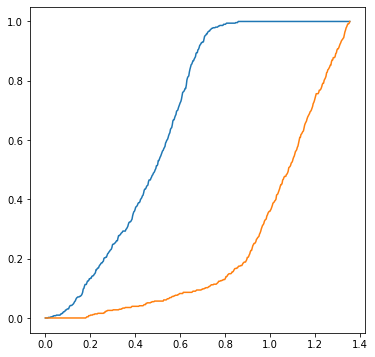

In [215]:
plt.plot(bs[0],densities[0])
plt.plot(bls[0],densities_l[0])

C:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(-2.0, 12.0)

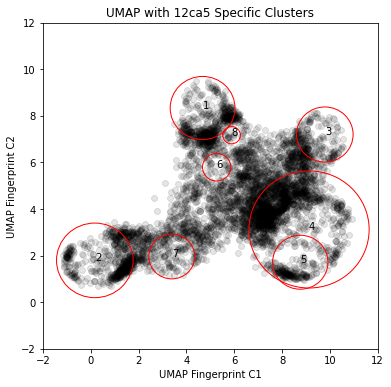

In [216]:
fig,ax = plt.subplots(figsize=(6,6))
ax.scatter(data_lib_all['C1'],data_lib_all['C2'],c='k',alpha=0.1)
centers = []
for i,e in enumerate(uniq_clusters):
    rows = data_final.query('Cluster == @i')
    x = rows['C1']
    y = rows['C2']
    cent_x = np.average(x)
    cent_y = np.average(y)
    if not math.isnan(cent_x):
        centers.append((cent_x,cent_y))
    plt.annotate(i,(cent_x,cent_y))
#     ax.scatter(x,y,label=f'Cluster {i}',c=cmap[i])
    if e > 0:
#         circle = plt.Circle((cent_x,cent_y),r_50s[e-1])
        circle2 = plt.Circle((cent_x,cent_y),r_50s[int(e-1)]*factor,fill=False,color='red')
#         ax.add_artist(circle)
        ax.add_artist(circle2)
ax.set_title('UMAP with 12ca5 Specific Clusters')
ax.set_xlabel('UMAP Fingerprint C1')
ax.set_ylabel('UMAP Fingerprint C2')
ax.set_xlim([-2,12])
ax.set_ylim([-2,12])

(-2.0, 12.0)

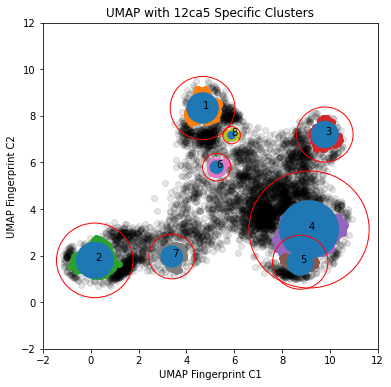

In [217]:
fig,ax = plt.subplots(figsize=(6,6))
ax.scatter(data_lib_all['C1'],data_lib_all['C2'],c='k',alpha=0.1)
centers = []
for i,e in enumerate(uniq_clusters):
    rows = data_final.query('Cluster == @i')
    x = rows['C1']
    y = rows['C2']
    cent_x = np.average(x)
    cent_y = np.average(y)
    if not math.isnan(cent_x):
        centers.append((cent_x,cent_y))
    plt.annotate(i,(cent_x,cent_y))
    ax.scatter(x,y,label=f'Cluster {i}',c=cmap[i])
    if e > 0:
        circle = plt.Circle((cent_x,cent_y),r_50s[int(e-1)])
        circle2 = plt.Circle((cent_x,cent_y),r_50s[int(e-1)]*factor,fill=False,color='red')
        ax.add_artist(circle)
        ax.add_artist(circle2)
ax.set_title('UMAP with 12ca5 Specific Clusters')
ax.set_xlabel('UMAP Fingerprint C1')
ax.set_ylabel('UMAP Fingerprint C2')
ax.set_xlim([-2,12])
ax.set_ylim([-2,12])

### Percent/ratio of points thing that Joe wants

In [218]:
data_ratio = pd.concat([data_clus,data_lib])
uniq_clusters = np.unique(data_ratio['Cluster'])

In [219]:
data_ratio

,Peptide,C1,C2,Cluster,Label
0,VWRDAEDYATFP,4.487755,8.108466,1.0,NaN
1,TPDWDGPDYAAH,-0.384460,1.382179,2.0,NaN
2,EMDAPDYASWEP,10.274223,7.065327,3.0,NaN
3,SVEDDAPDYADF,-0.482243,1.395353,2.0,NaN
4,MMDMDLQDYAGL,0.670447,1.537157,2.0,NaN
...,...,...,...,...,...
9146,AHQAFAKNMGNK,1.661376,1.609906,0.0,Library
9147,NTVKSLANVFTG,4.482827,2.212270,0.0,Library
9148,PGLPQNPAYKQD,-0.910443,2.318765,0.0,Library
9149,TDAWSEGQKFTA,10.148891,2.012675,0.0,Library


In [220]:
for i,center in enumerate(centers):
    dists = []
    for C1,C2 in zip(data_ratio['C1'],data_ratio['C2']):
        dists.append(np.sqrt((C1-center[0])**2 + (C2-center[1])**2))
    data_ratio[f'Distance from {i+1}'] = dists

In [221]:
for i,r50 in enumerate(r_50s):
    r = []
    for d in data_ratio[f'Distance from {i+1}']:
        r.append(d/r50)
    data_ratio[f'Normed_distance_from_{i+1}'] = r

In [222]:
data_ratio.query('Cluster == 1')

,Peptide,C1,C2,Cluster,Label,Distance from 1,Distance from 2,Distance from 3,Distance from 4,Distance from 5,...,Distance from 7,Distance from 8,Normed_distance_from_1,Normed_distance_from_2,Normed_distance_from_3,Normed_distance_from_4,Normed_distance_from_5,Normed_distance_from_6,Normed_distance_from_7,Normed_distance_from_8
0,VWRDAEDYATFP,4.487755,8.108466,1.0,NaN,0.294569,7.648681,5.376493,6.810503,7.689409,...,6.244253,1.686105,0.434762,9.552148,9.092549,5.420095,13.280761,8.257665,12.997019,9.124753
11,ALFDLEDYAKLN,4.860056,8.214686,1.0,NaN,0.220153,7.950410,5.030354,6.643616,7.579786,...,6.423899,1.466444,0.324929,9.928967,8.507172,5.287279,13.091426,8.301834,13.370940,7.936010
21,MDFDKPDYSALK,4.207049,7.882491,1.0,NaN,0.651674,7.304419,5.621376,6.845725,7.665944,...,5.976984,1.825814,0.961824,9.122213,9.506689,5.448126,13.240233,7.917653,12.440716,9.880824
33,VYDDLHDYASWP,4.384833,8.676353,1.0,NaN,0.448397,8.069466,5.600411,7.303009,8.221946,...,6.788071,2.128866,0.661802,10.077651,9.471234,5.812053,14.200533,10.193359,14.128941,11.520863
34,SWFDMADYAEWP,4.416216,8.400250,1.0,NaN,0.267625,7.852298,5.503309,7.074365,7.972406,...,6.519982,1.918898,0.394995,9.806438,9.307017,5.630087,13.769539,9.270692,13.570931,10.384567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4052,DGSDLPDYAVGQ,4.219315,8.093728,1.0,NaN,0.516426,7.487982,5.638879,6.985629,7.829754,...,6.187928,1.907596,0.762208,9.351457,9.536289,5.559467,13.523158,8.544049,12.879781,10.323405
4056,RFQDVQDYAHDM,4.778531,8.320582,1.0,NaN,0.103751,7.988836,5.132341,6.777146,7.712554,...,6.509092,1.599205,0.153130,9.976955,8.679649,5.393548,13.320735,8.703083,13.548264,8.654476
4069,FTRDLHDYAQYP,4.458135,8.601164,1.0,NaN,0.343693,8.044294,5.510118,7.198233,8.119307,...,6.725002,2.023866,0.507266,10.046215,9.318533,5.728668,14.023260,9.879144,13.997667,10.952626
4082,WNRDVPDYAGVQ,4.169920,8.194273,1.0,NaN,0.525154,7.546441,5.704351,7.091971,7.940328,...,6.281219,2.000592,0.775089,9.424464,9.647013,5.644099,13.714136,8.922780,13.073960,10.826677


In [226]:
r50_ranges = [np.linspace(r_p1,r_50*20,steps) for r_p1,r_50 in zip(r_p1s,r_50s)]
sums_target = []
sums_lib = []

for i,r50_range in enumerate(r50_ranges):
    points_t = []
    points_l = []
    target = data_ratio.copy().query(f'Cluster == {i+1}')
    lib = data_ratio.copy().query(f'Cluster != {i+1}')
    for thresh in r50_range:
        val_t = len(target.query(f'Normed_distance_from_{i+1} <= @thresh'))
        val_l = len(lib.query(f'Normed_distance_from_{i+1} <= @thresh'))
#         print(thresh,val_t,val_l)
        points_t.append(val_t)
        points_l.append(val_l)
    sums_target.append(points_t)
    sums_lib.append(points_l)

In [231]:
r50_ranges[-1]

array([0.06159453, 0.09830238, 0.13501023, 0.17171808, 0.20842593,
       0.24513379, 0.28184164, 0.31854949, 0.35525734, 0.39196519,
       0.42867304, 0.46538089, 0.50208874, 0.53879659, 0.57550444,
       0.6122123 , 0.64892015, 0.685628  , 0.72233585, 0.7590437 ,
       0.79575155, 0.8324594 , 0.86916725, 0.9058751 , 0.94258296,
       0.97929081, 1.01599866, 1.05270651, 1.08941436, 1.12612221,
       1.16283006, 1.19953791, 1.23624576, 1.27295361, 1.30966147,
       1.34636932, 1.38307717, 1.41978502, 1.45649287, 1.49320072,
       1.52990857, 1.56661642, 1.60332427, 1.64003213, 1.67673998,
       1.71344783, 1.75015568, 1.78686353, 1.82357138, 1.86027923,
       1.89698708, 1.93369493, 1.97040279, 2.00711064, 2.04381849,
       2.08052634, 2.11723419, 2.15394204, 2.19064989, 2.22735774,
       2.26406559, 2.30077344, 2.3374813 , 2.37418915, 2.410897  ,
       2.44760485, 2.4843127 , 2.52102055, 2.5577284 , 2.59443625,
       2.6311441 , 2.66785196, 2.70455981, 2.74126766, 2.77797

In [232]:
data_ratio['Normed_distance_from_8'].sort_values()

1708     0.196273
822      0.201732
3950     0.357538
1945     0.362215
2577     0.375814
          ...    
8788    48.819108
8129    48.894033
4427    48.915891
8114    48.964099
8597    49.023697
Name: Normed_distance_from_8, Length: 9151, dtype: float64

In [242]:
def util_func(a, b,opt):
    try:
        return a/b
    except ZeroDivisionError as e:
        print("division by zero error :(")
        if opt:
            return 1
        else:
            return 0

division by zero error :(
division by zero error :(
division by zero error :(
division by zero error :(
division by zero error :(
division by zero error :(
division by zero error :(
division by zero error :(


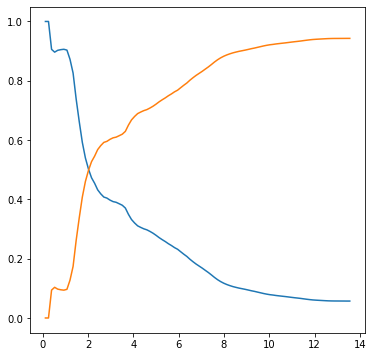

In [243]:
ratios_sum_t = [[util_func(t,t+l,True) for t,l in zip(s_t,s_l)] for s_t,s_l in zip(sums_target,sums_lib)]
ratios_sum_l = [[util_func(l,t+l,False) for t,l in zip(s_t,s_l)] for s_t,s_l in zip(sums_target,sums_lib)]

plt.plot(r50_ranges[0],ratios_sum_t[0])
plt.plot(r50_ranges[0],ratios_sum_l[0])
# plt.xlim([0,3])

In [244]:
r50_ranges_norm = []
for ran,r_50 in zip(r50_ranges,r_50s):
    sub_range = [r/r_50 for r in ran]
    r50_ranges_norm.append(sub_range)

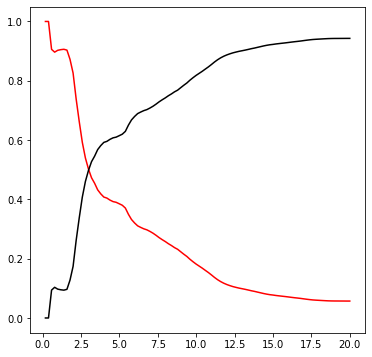

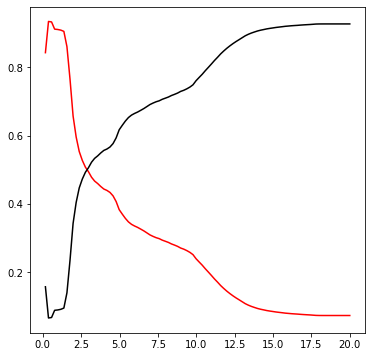

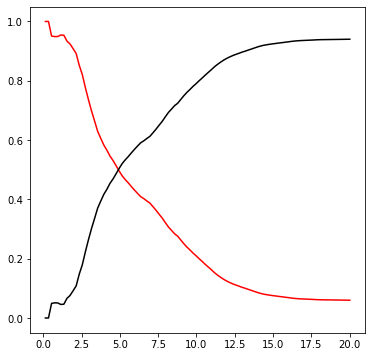

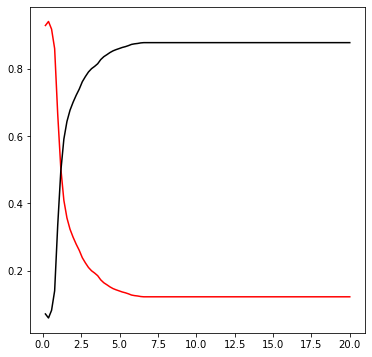

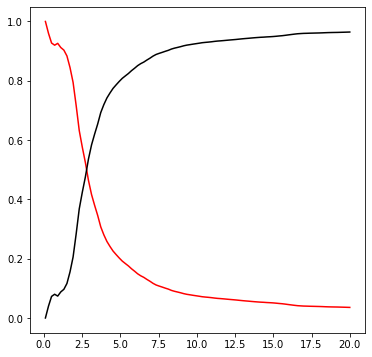

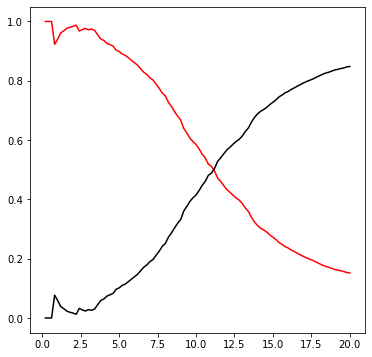

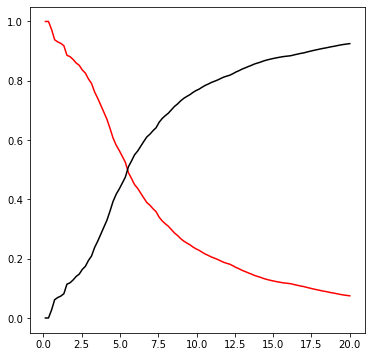

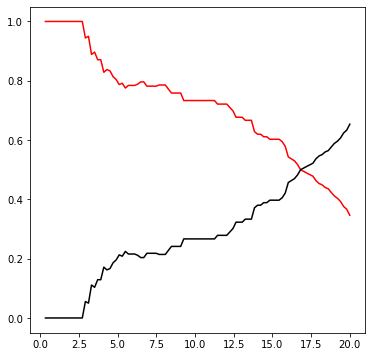

In [246]:
for ran,rat_t,rat_l in zip(r50_ranges_norm,ratios_sum_t,ratios_sum_l):
    fig, ax = plt.subplots()
    ax.plot(ran,rat_t,'r-')
    ax.plot(ran,rat_l,'k-')
#     fig.show()

In [253]:
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return y

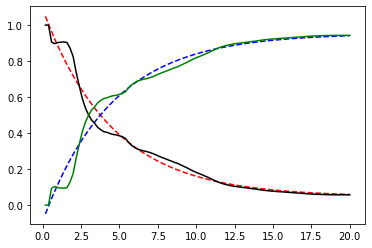

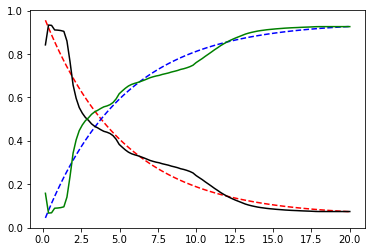

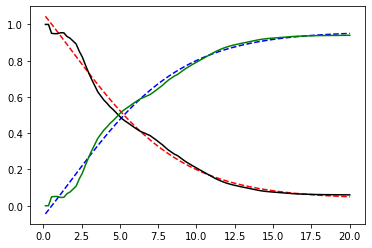

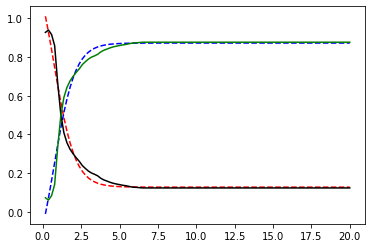

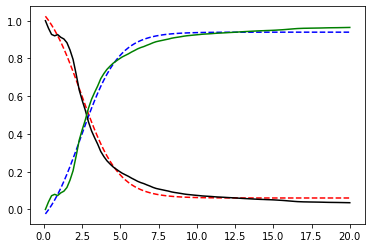

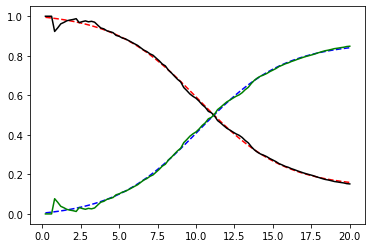

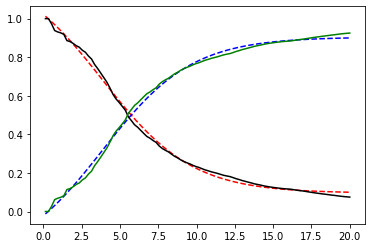

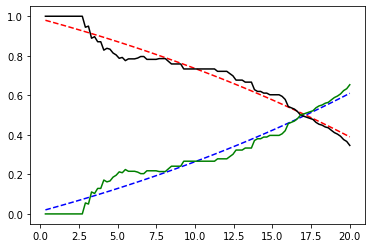

In [265]:
popt_target = []
for ran,rat_t,rat_l in zip(r50_ranges_norm,ratios_sum_t,ratios_sum_l):
    fig, ax = plt.subplots()
    p0 = [max(rat_t), np.median(ran),1,min(rat_t)]
    popt, pcov = curve_fit(sigmoid, ran, rat_t,p0, method='lm',maxfev=10000)
    
    y_pred = sigmoid(ran,*popt)
    ax.plot(ran,y_pred,'r--')
    ax.plot(ran,[1 - y for y in y_pred],'b--')
    ax.plot(ran,rat_t,'k-')
    ax.plot(ran,rat_l,'g-')
    popt_target.append(popt)

C:\Anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


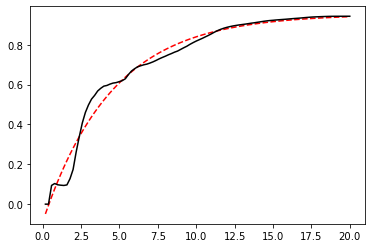

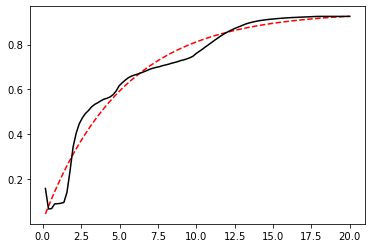

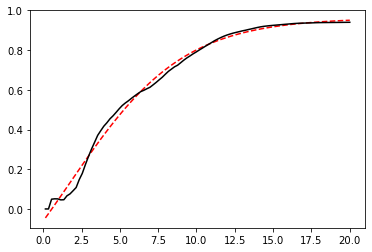

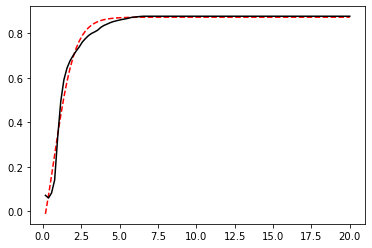

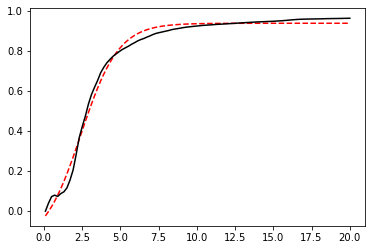

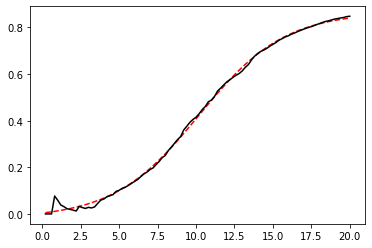

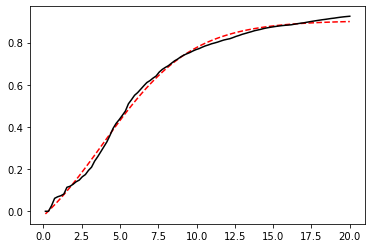

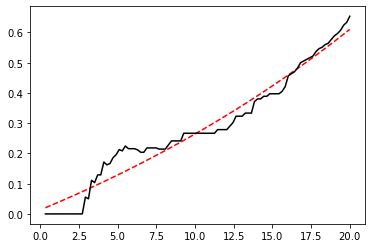

In [264]:
popt_lib = []
### could also just subtract the target values from 1 

for ran,rat_l in zip(r50_ranges_norm,ratios_sum_l):
    fig, ax = plt.subplots()
    p0 = [max(rat_l), np.median(ran),1,min(rat_l)]
    popt, pcov = curve_fit(sigmoid, ran, rat_l,p0, method='lm',maxfev=10000)
    popt_lib.append(popt)
    ax.plot(ran,sigmoid(ran,*popt),'r--')
    ax.plot(ran,rat_l,'k-')
    popt_target.append(popt)